# Project 4b - Image Warping and Mosaicing

### Dependencies

In [1]:
import numpy as np
from typing import List, Tuple
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from harris import get_harris_corners, dist2
from utils import computeH, warpImage, warpPoints, align_and_blend_images_custom

## Interest Point Detector

In [2]:
# Load images and points
image_left = plt.imread('../data/4a/img/IMG_8405.jpeg')
image_right = plt.imread('../data/4a/img/IMG_8406.jpeg')

# make panoramal left b&w
image_left_gray = np.mean(image_left, axis=2)
image_right_gray = np.mean(image_right, axis=2)

h_left, coords_left = get_harris_corners(image_left_gray)
h_right, coords_right = get_harris_corners(image_right_gray)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display Harris corners for the left image
plt.subplot(1, 2, 1)
plt.imshow(image_left)
plt.scatter(coords_left[1], coords_left[0], c='b', s=0.1)
plt.title('Harris Corners Left')
plt.axis('off')

# Display Harris corners for the right image
plt.subplot(1, 2, 2)
plt.imshow(image_right)
plt.scatter(coords_right[1], coords_right[0], c='b', s=0.1)
plt.title('Harris Corners Right')
plt.axis('off')

plt.show()

## Adaptive Non-Maximal Suppression

In [4]:
def adaptive_non_maximal_suppression(corners: np.ndarray, h: np.ndarray, num_points: int = 500, c_robust: float = 0.9) -> np.ndarray:
    # Extract Harris strengths for each corner point
    scores = h[corners[0], corners[1]]
    
    # Calculate pairwise distances between all corners using dist2()
    dists = dist2(corners.T, corners.T)  # corners.T is of shape (n, 2)
    
    # Broadcast comparison: f(x_i) < c_robust * f(x_j)
    larger_mask = scores[:, np.newaxis] < (c_robust * scores[np.newaxis, :])
    
    # Mask the distances where the comparison holds and set the rest to infinity
    masked_dists = np.where(larger_mask, dists, np.inf)
    
    # Calculate the minimum radius for each point
    radii = np.min(masked_dists, axis=1)
    
    # Sort points by their radii in descending order
    sorted_indices = np.argsort(-radii)
    
    # Sort the original corners based on radii
    sorted_corners = corners[:, sorted_indices]
    
    # Return the top 'num_points' corners
    return sorted_corners[:, :num_points]

# Apply Adaptive Non-Maximal Suppression to get top corners
suppressed_coords_left = adaptive_non_maximal_suppression(coords_left, h_left)
suppressed_coords_right = adaptive_non_maximal_suppression(coords_right, h_right)

In [ ]:
# Display ANMS corners
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_left)
plt.scatter(suppressed_coords_left[1], suppressed_coords_left[0], c='r', s=2)
plt.title('ANMS Corners Left')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_right)
plt.scatter(suppressed_coords_right[1], suppressed_coords_right[0], c='r', s=2)
plt.title('ANMS Corners Right')
plt.axis('off')

plt.show()

## Feature Descriptor Extraction

In [6]:
def extract_feature_descriptors(im: np.ndarray, coords: np.ndarray, patch_size: int = 8, window_size: int = 40, spacing: int = 5) -> np.ndarray:
    # Calculate half the window size for boundary checks
    half_window = window_size // 2

    # Check if the point is within the valid bounds of the image
    def is_within_bounds(y, x):
        return (half_window <= y < im.shape[0] - half_window and 
                half_window <= x < im.shape[1] - half_window)

    # Extract and normalize an 8x8 patch from a 40x40 window around the point (y, x) for a given channel
    def extract_patch(y, x, channel):
        # Extract the 40x40 window for the current channel
        window = im[y-half_window:y+half_window, x-half_window:x+half_window, channel]
        # Apply Gaussian blur to reduce aliasing
        window = gaussian_filter(window, sigma=1)
        # Sample an 8x8 patch from the window with specified spacing
        patch = window[::spacing, ::spacing][:patch_size, :patch_size]
        # Normalize the patch (bias/gain normalization)
        patch_mean = np.mean(patch)
        patch_std = np.std(patch)
        return (patch - patch_mean) / patch_std if patch_std > 0 else patch

    # Generate descriptors for each point in coords
    descriptors = [
        # Concatenate descriptors from all three channels to form a single vector
        np.concatenate([extract_patch(y, x, channel).flatten() for channel in range(3)])
        for y, x in coords.T if is_within_bounds(y, x)
    ]

    return np.array(descriptors)

descriptors_left = extract_feature_descriptors(image_left, suppressed_coords_left)
descriptors_right = extract_feature_descriptors(image_right, suppressed_coords_right)

In [ ]:
def visualize_descriptors(descriptors: np.ndarray, num_descriptors: int = 5, patch_size: int = 8) -> None:
    fig, axes = plt.subplots(1, num_descriptors, figsize=(15, 5))

    for i, ax in enumerate(axes[:num_descriptors]):
        descriptor = descriptors[i]
        
        # Reshape the descriptor into three 8x8 patches for R, G, B channels
        patches = [descriptor[j*patch_size*patch_size:(j+1)*patch_size*patch_size].reshape((patch_size, patch_size)) for j in range(3)]
        
        # Combine the patches into a single 8x8x3 RGB image
        patch_rgb = np.stack(patches, axis=-1)
        
        # Normalize the RGB image to [0, 1] for visualization
        patch_rgb = (patch_rgb - patch_rgb.min()) / (patch_rgb.max() - patch_rgb.min())
        
        # Display the RGB image
        ax.imshow(patch_rgb)
        ax.axis('off')
        ax.set_title(f'Descriptor {i+1}')
    
    plt.show()

visualize_descriptors(descriptors_left, num_descriptors=5)
visualize_descriptors(descriptors_right, num_descriptors=5)

## Feature Matching

In [8]:
def match_features(descriptors1: np.ndarray, descriptors2: np.ndarray, ratio_threshold: float = 0.8) -> List[Tuple[int, int]]:
    
    matches = []
    matched_in_second_image = set()  # Track points already matched in the second image
    
    for i, desc1 in enumerate(descriptors1):
        # Calculate distances to all descriptors in the second image
        distances = np.linalg.norm(descriptors2 - desc1, axis=1)
        
        # Get the two nearest neighbors
        nearest_neighbor_idx, second_nearest_neighbor_idx = np.argsort(distances)[:2]
        
        # Apply Lowe's ratio test
        if distances[nearest_neighbor_idx] < ratio_threshold * distances[second_nearest_neighbor_idx]:
            # Ensure one-to-one matching
            if nearest_neighbor_idx not in matched_in_second_image:
                matches.append((i, nearest_neighbor_idx))
                matched_in_second_image.add(nearest_neighbor_idx)
    
    return matches

matches = match_features(descriptors_left, descriptors_right)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(image_left, cmap='gray')
ax[0].set_title('Left Image')
ax[1].imshow(image_right, cmap='gray')
ax[1].set_title('Right Image')

for idx, (i, j) in enumerate(matches):
    y1, x1 = suppressed_coords_left[:, i]
    y2, x2 = suppressed_coords_right[:, j]
    
    # plot the points on the image
    ax[0].scatter(x1, y1, c='y', s=5)
    ax[1].scatter(x2, y2, c='y', s=5)

    # Remove axis
    ax[0].axis('off')
    ax[1].axis('off')

    # number the points on both images
    ax[0].text(x1, y1, str(idx), fontsize=11, color='r')
    ax[1].text(x2, y2, str(idx), fontsize=11, color='r')

plt.show()

## 4-Point RANSAC

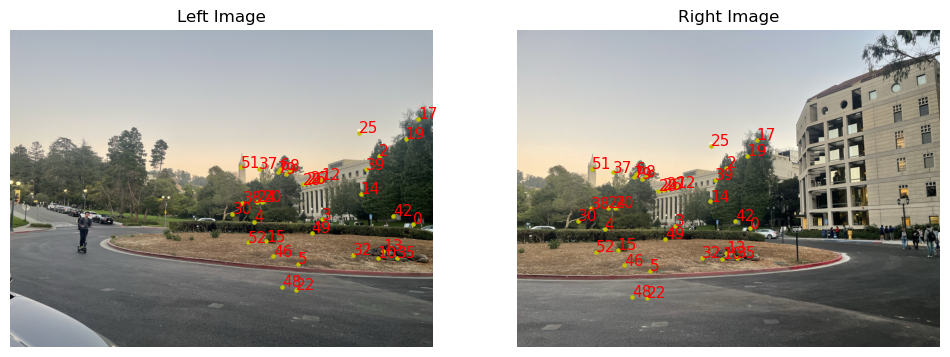

[[ 2.29615679e+00 -1.02262136e-01 -1.18204766e+03]
 [ 5.72408999e-01  1.85924511e+00 -4.59543966e+02]
 [ 1.01958010e-03 -4.23455002e-05  1.00000000e+00]]


In [137]:
import numpy as np
import matplotlib.pyplot as plt

def warpPoints_Ransac(points, H):
    num_points = points.shape[0]
    homogeneous_points = np.hstack([points, np.ones((num_points, 1))])
    warped_points = H @ homogeneous_points.T
    warped_points /= warped_points[2, :]
    return warped_points[:2, :].T

def RANSAC(coords_1, coords_2, matches_b, nbr_iter=10000, epsilon=1):
    pts1 = []
    pts2 = []
    
    for idx, (i, j) in enumerate(matches_b):
        y1, x1 = coords_1[:, i]
        y2, x2 = coords_2[:, j]
        pts1.append([x1, y1])
        pts2.append([x2, y2])

    pts1 = np.array(pts1)
    pts2 = np.array(pts2)

    best_H = None
    max_inliers = 0
    best_inliers = []

    for iter in range(nbr_iter):
        random_indices = np.random.choice(len(matches_b), 4, replace=False)
        selected_pts1 = pts1[random_indices]
        selected_pts2 = pts2[random_indices]
        
        H_temp = computeH(selected_pts1, selected_pts2)
        
        inliers = []
        for idx in range(len(pts1)):
            pt1 = pts1[idx]
            pt2 = pts2[idx]
            warped_pt1 = warpPoints_Ransac(np.array([pt1]), H_temp)[0]
            dist = np.linalg.norm(warped_pt1 - pt2)
            if dist < epsilon:
                inliers.append(idx)

        if len(inliers) > max_inliers:
            max_inliers = len(inliers)
            best_H = H_temp
            best_inliers = inliers

    if max_inliers < 4:
        raise ValueError("Not enough inliers to compute a homography.")

    final_pts1 = pts1[best_inliers]
    final_pts2 = pts2[best_inliers]
    final_H = computeH(final_pts1, final_pts2)

    return final_H, best_inliers, final_pts1, final_pts2

# Example usage
best_H, best_inliers, best_im1_pts, best_im2_pts = RANSAC(suppressed_coords_left, suppressed_coords_right, matches)

# Initialize lists to store inlier coordinates
inlier_coords_left = []
inlier_coords_right = []

plt.figure(figsize=(12, 6))

# Display the left image
plt.subplot(1, 2, 1)
plt.imshow(image_left, cmap='gray')
plt.title('Left Image')

# Display the right image
plt.subplot(1, 2, 2)
plt.imshow(image_right, cmap='gray')
plt.title('Right Image')

# Loop through matches and process inliers
for idx, (i, j) in enumerate(matches):
    if idx in best_inliers:
        y1, x1 = suppressed_coords_left[:, i]
        y2, x2 = suppressed_coords_right[:, j]
        
        inlier_coords_left.append([y1, x1])
        inlier_coords_right.append([y2, x2])
        
        plt.subplot(1, 2, 1)
        plt.axis('off')
        plt.scatter(x1, y1, c='y', s=5)
        plt.text(x1, y1, str(idx), fontsize=11, color='r')
        
        plt.subplot(1, 2, 2)
        plt.axis('off')
        plt.scatter(x2, y2, c='y', s=5)
        plt.text(x2, y2, str(idx), fontsize=11, color='r')

plt.show()

# Convert lists to NumPy arrays
inlier_coords_left = np.array(inlier_coords_left)
inlier_coords_right = np.array(inlier_coords_right)

final_H = computeH(best_im1_pts, best_im2_pts)
print(final_H)

In [ ]:
# Correct H2
# [[ 2.39875461e+00 -1.07312014e-01 -1.24265452e+03]
# [ 6.13879567e-01  1.91272209e+00 -4.89303216e+02]
# [ 1.10968064e-03 -7.69086616e-05  1.00000000e+00]]

### Test code to manually choosing points

In [ ]:
# Function to select points by given indices
def select_points_by_index(matches, coords_left, coords_right, indices):
    selected_im1_pts = []
    selected_im2_pts = []

    for idx in indices:
        i, j = matches[idx]  # Extract match at the given index
        y1, x1 = coords_left[:, i]
        y2, x2 = coords_right[:, j]

        selected_im1_pts.append([x1, y1])
        selected_im2_pts.append([x2, y2])

    return np.array(selected_im1_pts), np.array(selected_im2_pts)

# Plot function for selected points
def plot_selected_points(image_left, image_right, selected_im1_pts, selected_im2_pts):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Plot for the left image
    ax[0].imshow(image_left, cmap='gray')
    ax[0].set_title('Left Image')

    for idx, (x1, y1) in enumerate(selected_im1_pts):
        ax[0].scatter(x1, y1, c='y', s=10)
        ax[0].text(x1, y1, str(idx), fontsize=12, color='r')

    ax[0].axis('off')

    # Plot for the right image
    ax[1].imshow(image_right, cmap='gray')
    ax[1].set_title('Right Image')

    for idx, (x2, y2) in enumerate(selected_im2_pts):
        ax[1].scatter(x2, y2, c='y', s=10)
        ax[1].text(x2, y2, str(idx), fontsize=12, color='r')

    ax[1].axis('off')
    plt.show()

# Example usage
indices_to_pick = [16, 40, 18, 25]  # Indices of matches to select
im1_pts, im2_pts = select_points_by_index(matches, suppressed_coords_left, suppressed_coords_right, indices_to_pick)

# Plot selected points on both images
plot_selected_points(image_left, image_right, im1_pts, im2_pts)

# Now you can compute the homography with these selected points
H_selected = computeH(im1_pts, im2_pts)
print("Computed Homography Matrix:")
print(H_selected)

In [16]:
# Correct H2
# [[ 2.39875461e+00 -1.07312014e-01 -1.24265452e+03]
# [ 6.13879567e-01  1.91272209e+00 -4.89303216e+02]
# [ 1.10968064e-03 -7.69086616e-05  1.00000000e+00]]

### End of test code

In [148]:
# Warp the image
image_left_warped, min_x, min_y = warpImage(image_left, final_H)

# Warp the points
warped_points = warpPoints(best_im1_pts, final_H, min_x, min_y)

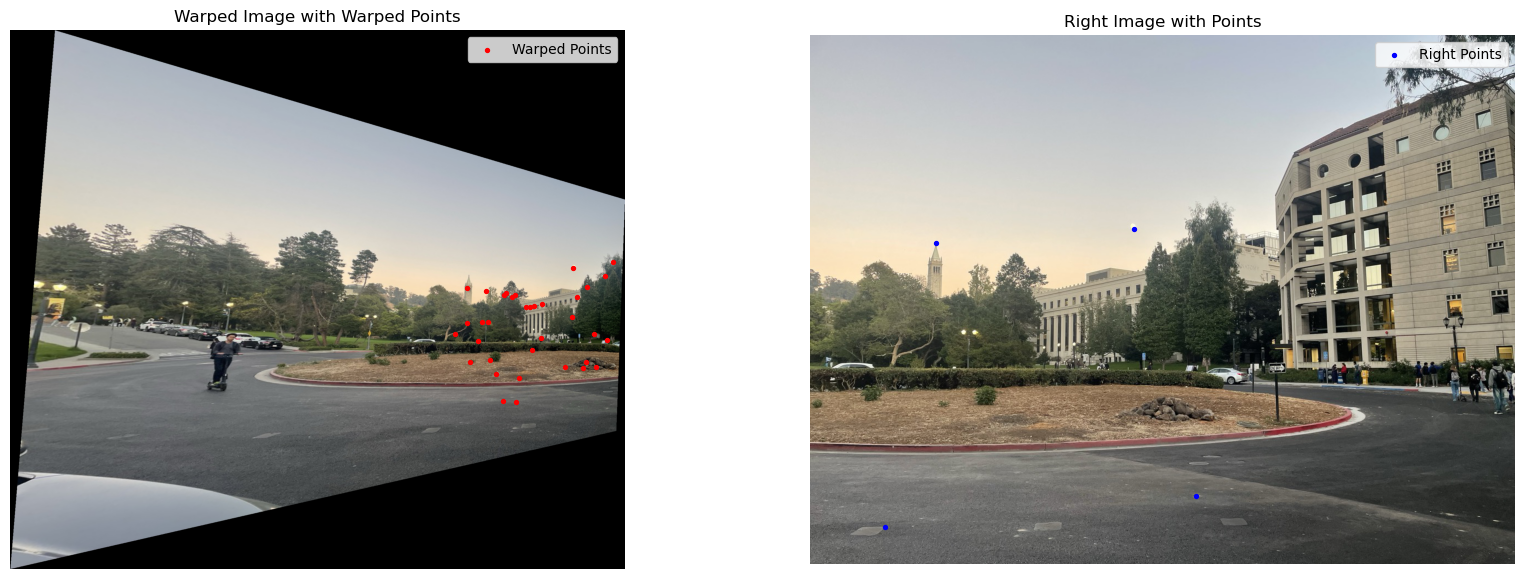

In [153]:
plt.figure(figsize=(20, 7))

# Display the warped image on the left
plt.subplot(1, 2, 1)
plt.imshow(image_left_warped, cmap='gray')
plt.scatter(warped_points[:, 0], warped_points[:, 1], c='r', s=8, label='Warped Points')
plt.legend()
plt.title('Warped Image with Warped Points')
plt.axis('off')

# Display the right image on the right
plt.subplot(1, 2, 2)
plt.imshow(image_right, cmap='gray')
plt.scatter(im2_pts[:, 0], im2_pts[:, 1], c='b', s=8, label='Right Points')
plt.legend()
plt.title('Right Image with Points')
plt.axis('off')

plt.show()

Warped Points:
 [[2038.37675049 1059.42073655]
 [1968.08494527  877.54216687]
 [1812.30330173 1051.3613112 ]
 [1598.46099594 1062.59288741]
 [1736.26965811 1188.43168429]
 [1692.45491116  896.65724774]
 [1686.68111969  905.64948135]
 [1724.7132856   902.86365397]
 [1711.860857    911.29360213]
 [1953.87630946 1152.70309255]
 [1815.47049707  935.82217023]
 [1967.14370304 1133.90070305]
 [1919.01934693  978.29451379]
 [1637.93848605 1124.74662619]
 [2059.15791751  792.66059384]
 [2030.36286497  840.41195438]
 [1630.42269617  997.63032142]
 [1727.480462   1270.64199821]
 [1609.76851416  997.37923664]
 [1921.81182223  810.44471336]
 [1775.04629171  943.79737215]
 [1787.74998036  941.38397939]
 [1762.16209991  946.24505614]
 [1519.29085284 1037.05302041]
 [1893.49058407 1150.14058689]
 [1998.49085754 1149.11666694]
 [1623.0115412   889.93183505]
 [1558.50773845  998.97847444]
 [1934.01086343  912.56362258]
 [1994.60126262 1038.69178405]
 [1659.03014501 1172.18314299]
 [1682.76879542 1267.25

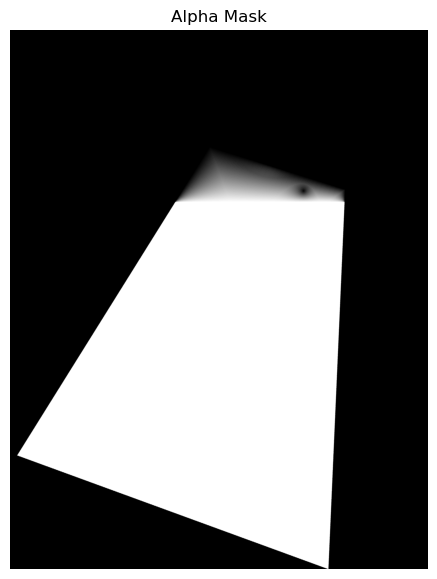

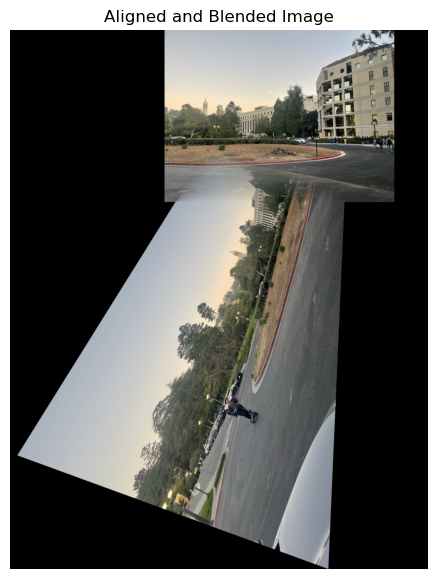

In [150]:
# Debugging: Display intermediate outputs
print("Warped Points:\n", warped_points)
print("Image Left Warped Shape:", image_left_warped.shape)
print("Image Right Shape:", image_right.shape)
print("im2_pts:\n", im2_pts)

# Align and blend the images
result_image = align_and_blend_images_custom(image_left_warped, image_right, warped_points, im2_pts)

# Display the result
plt.figure(figsize=(10, 7))
plt.imshow(result_image)
plt.title('Aligned and Blended Image')
plt.axis('off')
plt.show()

### Original RANSAC

In [ ]:
def apply_homography(H, points):
    num_pts = points.shape[0]
    points_homogeneous = np.hstack((points, np.ones((num_pts, 1))))
    transformed_points = (H @ points_homogeneous.T).T
    transformed_points /= transformed_points[:, 2][:, np.newaxis]
    return transformed_points[:, :2]

def ransac_homography(matches, coords_left, coords_right, num_iterations=500, threshold=5):
    best_H = None
    max_inliers = 0
    best_inliers = []

    for _ in range(num_iterations):
        # Randomly select 4 matches
        sample_indices = np.random.choice(len(matches), 4, replace=False)
        sample_matches = [matches[i] for i in sample_indices]

        im1_pts = np.array([coords_left[:, i] for i, _ in sample_matches])
        im2_pts = np.array([coords_right[:, j] for _, j in sample_matches])

        # Compute homography
        H = computeH(im1_pts, im2_pts)

        # Apply homography to all points
        all_im1_pts = np.array([coords_left[:, i] for i, _ in matches])
        all_im2_pts = np.array([coords_right[:, j] for _, j in matches])
        transformed_pts = apply_homography(H, all_im1_pts)

        # Compute inliers
        distances = np.linalg.norm(transformed_pts - all_im2_pts, axis=1)
        inliers = distances < threshold
        num_inliers = np.sum(inliers)

        if num_inliers > max_inliers:
            max_inliers = num_inliers
            best_H = H
            best_inliers = inliers

    return best_H, best_inliers, im1_pts, im2_pts

# Example usage
# Assuming matches, suppressed_coords_left, and suppressed_coords_right are defined
best_H, best_inliers, best_im1_pts, best_im2_pts = ransac_homography(matches, suppressed_coords_left, suppressed_coords_right)
print(best_H)